# Implementação Pix2Pix

**Nome:** Frederico Dolher Souza Baker

A tradução de imagens para imagens é uma tarefa fundamental na visão computacional, focando em transformar uma representação de uma cena em outra, com base em dados de treinamento adequados. Um dos desafios principais é definir uma função de perda eficaz que permita à rede neural aprender a prever pixels a partir de pixels.

No âmbito das redes neurais convolucionais (CNNs), pode-se pensar em utilizar a distância euclidiana como função de perda. No entanto, isso geralmente resulta em saídas borradas, pois a distância euclidiana minimiza a perda ao aproximar-se da média de todas as saídas possíveis para um pixel específico. Consequentemente, as imagens geradas tem pouca nitidez.

Para mitigar esse problema, é necessário desenvolver funções de perda que encorajem a geração de saídas realistas e nítidas. Idealmente, gostaríamos que a função de perda pudesse ser definida em um nível mais alto, como "Faça com que a saída seja indistinguível da realidade." Essa ideia é explorada pelas Redes Adversariais Generativas (GANs), que utilizam uma rede discriminadora para aprender a diferenciar imagens reais de geradas, enquanto a rede geradora tenta produzir imagens que enganem a discriminadora.

O Pix2Pix faz uso das GANs condicionais (cGANs), onde as saídas são condicionadas a entradas específicas, permitindo uma tradução de imagem para imagem mais precisa e alinhada com o contexto da entrada. Isso demonstra como as cGANs podem ser aplicadas como uma solução de propósito geral para tradução de imagens, abrangendo aplicações desde a transformação de esboços em fotografias até a coloração de imagens em preto e branco.

Para esse trabalho será utilizado o dataset [Facades](http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz) disponibilizado pelos próprios autores do paper que introduziu o Pix2Pix.

## Imports

In [2]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

## Carregamento do Conjunto de Dados

In [2]:
get_ipython().system('wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz')

--2024-08-19 23:53:43--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz’

facades.tar.gz      100%[===================>]  28.77M  6.09MB/s    in 9.2s    

2024-08-19 23:53:52 (3.13 MB/s) - ‘facades.tar.gz’ saved [30168306/30168306]



In [4]:
get_ipython().system("tar -zxf 'facades.tar.gz'")

In [5]:
dataset_path = "./facades/"

In [7]:
sample_image = tf.io.read_file(str(dataset_path + 'train/1.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(256, 512, 3)


Nesse dataset, cada imagem tem tamanho 256 x 512, de forma que contém duas imagens de 256 x 256 concatenadas.

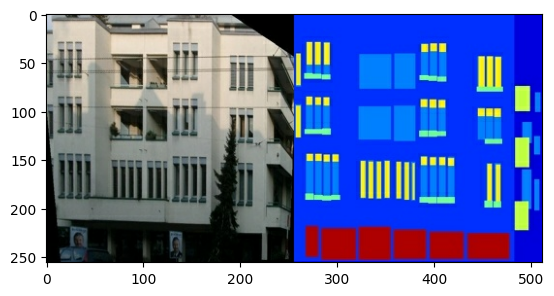

In [8]:
plt.figure()
plt.imshow(sample_image)

A seguir, define-se uma função para carregar uma imagem e separá-la em duas partes: a imagem real da fachada do edifício e sua respectiva segmentação.

In [9]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

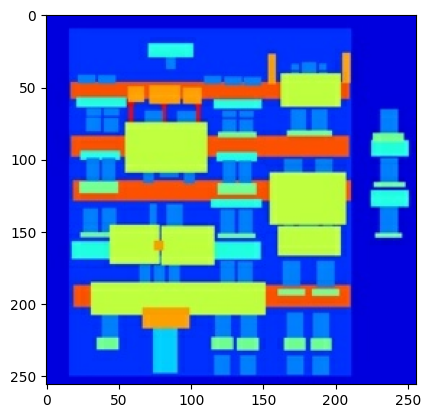

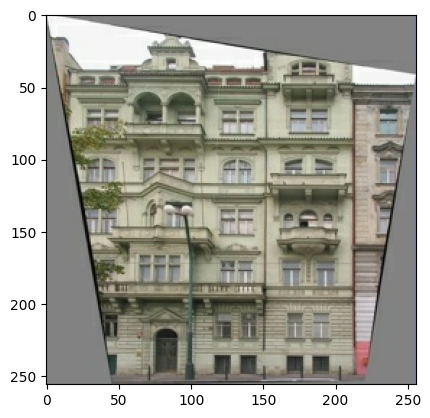

In [10]:
inp, re = load(str(dataset_path + 'train/100.jpg'))
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

## Pré-processamento dos Dados

Nos apêndices do artigo Pix2Pix, é detalhada a aplicação de um random jitter que redimensiona a imagem para 286 x 286 pixels e, em seguida, a corta aleatoriamente para 256 x 256 pixels. Além disso, é aplicado um espelhamento horizontal aleatório, seguido de uma normalização para o intervalo [-1, 1]. Esses processos são aplicados exclusivamente no conjunto de treinamento.

In [11]:
BUFFER_SIZE = 400

BATCH_SIZE = 1 # Best result in the Pix2Pix paper

IMG_WIDTH, IMG_HEIGHT= 256, 256

In [12]:
def resize(input_image, real_image, height, width):
    # Resize images using nearest neighbor interpolation
    input_image = tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

def random_crop(input_image, real_image):
    # Randomly crop both images, keeping them aligned
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [13]:
# Normalizes the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [14]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [15]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)  # Apply data augmentation
    input_image, real_image = normalize(input_image, real_image)  # Normalize to [-1, 1]

    return input_image, real_image

def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)  # Resize to target size
    input_image, real_image = normalize(input_image, real_image)  # Normalize to [-1, 1]

    return input_image, real_image

A seguir, é definido um pipeline de entrada de dados utilizando as funções criadas anteriormente.

In [16]:
train_dataset = tf.data.Dataset.list_files(str(dataset_path + 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [17]:
try:
    test_dataset = tf.data.Dataset.list_files(str(dataset_path + 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
    test_dataset = tf.data.Dataset.list_files(str(dataset_path + 'val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Construção do Gerador

O gerador é um modelo composto por um **encoder** e um **decoder**, também conhecidos como **downsampler** e **upsampler**, formando essencialmente uma U-Net modificada. A imagem abaixo ilustra a arquitetura da U-Net, onde o processo de geração de uma imagem de saída a partir de uma imagem de entrada envolve duas etapas principais:

1. **Downsampling**: O gerador reduz a imagem de entrada até uma camada de gargalo (*bottleneck layer*), onde aprende uma representação no espaço latente da imagem. Esse processo é representado pelas camadas à esquerda na imagem, que diminuem progressivamente a resolução da imagem original.

2. **Upsampling**: A partir dessa representação latente, o gerador realiza o upsampling até atingir o tamanho desejado da imagem de saída. Esse processo é representado pelas camadas à direita na imagem, que restauram a resolução da imagem.

O nome U-Net deriva do formato em "U" da rede, mostrado na imagem, onde **skip connections** são adicionadas entre as camadas correspondentes de downsampling e upsampling. Essas conexões diretas ajudam a preservar características importantes da imagem de entrada, permitindo que o gerador combine informações de diferentes resoluções.

No processo de **downsampling**, a rede aprende a identificar o conteúdo da imagem, enquanto no **upsampling**, ela aprende a reconstruir esses elementos na posição correta. Essa estrutura torna a U-Net particularmente eficaz em tarefas de segmentação e tradução de imagens.

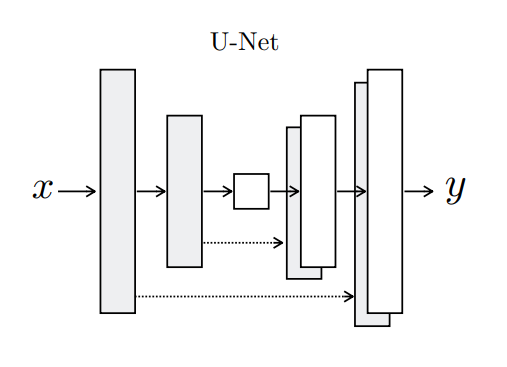

### Estrutura dos blocos do Gerador:

- **Encoder (Downsampler)**:
   - Convolução
   - Normalização em Batch
   - Leaky ReLU

- **Decoder (Upsampler)**:
   - Convolução Transposta
   - Normalização em Batch
   - Dropout
   - ReLU

In [18]:
OUTPUT_CHANNELS = 3

In [19]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())  # Apply BatchNorm if specified

    result.add(tf.keras.layers.LeakyReLU())  # Use LeakyReLU activation

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                               padding='same',
                                               kernel_initializer=initializer, use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())  # Apply BatchNorm

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))  # Apply Dropout if specified

    result.add(tf.keras.layers.ReLU())  # Use ReLU activation

    return result

In [20]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')  # Final layer (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling with skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

### Definindo a Função de Perda do Gerador

O gerador de uma Rede Adversarial Generativa Condicional (cGAN) é treinado para enganar o discriminador, fazendo com que ele classifique as imagens geradas como reais. Além disso, o gerador deve criar imagens semelhantes às do conjunto de dados original, minimizando a diferença entre as imagens de entrada e as geradas usando uma perda L1, ou Erro Médio Absoluto (MAE). Isso ajuda o gerador a aprender a produzir saídas que sejam visualmente realistas e consistentes com as imagens de destino.

Para equilibrar esses objetivos, a atualização do gerador é feita pela soma ponderada das perdas adversarial e L1. Os autores do Pix2Pix sugerem atribuir um peso de 100 para a perda L1 e um peso de 1 para a perda adversarial, incentivando o gerador a criar transformações plausíveis das imagens de entrada.

Para implementar isso, é criado um modelo composto que integra o gerador e o discriminador. Neste modelo, a imagem original é alimentada no gerador, e a saída gerada é passada como entrada "alvo" para o discriminador. O discriminador, então, avalia se a imagem gerada parece uma tradução autêntica da imagem de origem.

Durante o treinamento, o discriminador é atualizado separadamente, e seus pesos são mantidos fixos quando o modelo composto é atualizado. O modelo composto aprende a classificar as imagens geradas como reais (usando perda de entropia cruzada) e também compara a tradução gerada com a imagem real (usando perda L1).

Essa abordagem permite que o gerador melhore constantemente, produzindo imagens que são tanto realistas quanto fiéis às entradas originais.

In [21]:
LAMBDA = 100

In [22]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [23]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

## Construção do Discriminador

O discriminador no Pix2Pix prediz a probabilidade de uma imagem ser real em relação a uma imagem de destino, utilizando a abordagem chamada PatchGAN. Esta técnica classifica se cada patch (bloco) da imagem é real ou não.

No artigo do Pix2Pix, define-se que cada predição lida com patches de tamanho 70x70 pixels. A principal vantagem dessa abordagem é que ela pode ser aplicada a imagens de diferentes tamanhos, mantendo a capacidade de detectar características locais em diversas escalas.

### Estrutura dos Blocos do Discriminador:

 - Convolução
 - Normalização em Batch
 - Leaky ReLU

O discriminador recebe duas entradas: a imagem de entrada e a imagem de destino. Ele concatena essas imagens e as processa juntas para determinar se a imagem de entrada é uma tradução realista da imagem de destino.

In [24]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # Concatenate input and target (batch_size, 256, 256, 6)

    down1 = downsample(64, 4, False)(x)  # Downsample to (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # Downsample to (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # Downsample to (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # Zero padding to (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)  # Convolution to (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # Zero padding to (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2)  # Final output (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

### Definindo a Função de Perda do Discriminador

A função de perda do discriminador é relativamente simples, baseada na entropia cruzada entre as saídas previstas e os valores esperados. O discriminador é treinado para identificar corretamente as imagens reais como reais e as imagens geradas como falsas. Portanto, a perda do discriminador é calculada como a soma da entropia cruzada desses dois cenários: classificações corretas das imagens reais e classificações corretas das imagens falsas.

In [25]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)  # Loss for real images

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)  # Loss for generated images

    total_disc_loss = real_loss + generated_loss  # Sum the losses

    return total_disc_loss

## Definindo o Otimizador

Para o treinamento do modelo, utiliza-se o otimizador Adam com uma taxa de aprendizado (learning rate) de 0.0002 e um parâmetro beta de 0.5, conforme especificado no artigo.

In [26]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [27]:
generator = Generator()
discriminator = Discriminator()

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Treinamento do Modelo

A seguir, são definidas as funções necessárias para o treinamento do modelo, incluindo uma função para geração de imagens que plota as imagens preditas à medida que o treinamento avança. O modelo foi treinado por 200 épocas, conforme recomendado pelo artigo original, o que permitiu ao modelo alcançar um nível de maturidade adequado durante o treinamento. O tamanho do lote (batch size) foi configurado para 1, seguindo a abordagem utilizada no trabalho original para capturar mais detalhes na geração de imagens.

In [28]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Scale pixel values to [0, 1] for visualization
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')

    plt.show()

In [29]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

A função `train_step` realiza um único passo de treinamento no modelo Pix2Pix. Ela utiliza `tf.GradientTape` para calcular os gradientes das perdas do gerador e do discriminador. Em seguida, os gradientes são aplicados aos otimizadores correspondentes, permitindo a atualização dos pesos das redes. Este processo é fundamental para ajustar o gerador a produzir imagens mais realistas, enquanto o discriminador aprende a distinguir entre imagens reais e geradas, mantendo o equilíbrio necessário para o sucesso do treinamento de GANs.


In [30]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    # Calculate gradients for generator and discriminator
    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients to optimize the models
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_total_loss, disc_loss

A função `fit` gerencia o processo de treinamento ao longo de várias épocas. Durante cada época, as perdas médias do gerador e do discriminador são acumuladas, permitindo uma análise detalhada do progresso do treinamento. Além disso, é realizada uma validação periódica para monitorar a capacidade do modelo de generalizar para dados não vistos. O modelo é salvo ao final de cada época para facilitar a retomada do treinamento ou a avaliação posterior dos resultados. Este método sistemático assegura que o treinamento seja conduzido de maneira controlada e eficaz.


In [31]:
def fit(train_ds, val_ds, epochs):
    example_input, example_target = next(iter(val_ds.take(1)))
    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()

    # Initialize lists to store losses
    gen_train_losses = []
    disc_train_losses = []
    gen_val_losses = []
    disc_val_losses = []

    for epoch in range(epochs):
        start = time.time()

        print(f"Epoch {epoch+1}/{epochs}")

        gen_train_loss_epoch = 0
        disc_train_loss_epoch = 0

        for step, (input_image, target) in train_ds.take(steps_per_epoch).enumerate():
            gen_loss, disc_loss = train_step(input_image, target)

            # Accumulate training losses for the epoch
            gen_train_loss_epoch += gen_loss
            disc_train_loss_epoch += disc_loss

            if (step + 1) % 100 == 0:
                print(f'Step {step+1}/{steps_per_epoch} - Gen Loss: {gen_loss:.4f} - Disc Loss: {disc_loss:.4f}')

        # Store average loss per epoch
        gen_train_losses.append(gen_train_loss_epoch / steps_per_epoch)
        disc_train_losses.append(disc_train_loss_epoch / steps_per_epoch)

        # Validate at the end of each epoch
        val_gen_loss, val_disc_loss = validate(val_ds)
        gen_val_losses.append(val_gen_loss)
        disc_val_losses.append(val_disc_loss)

        print(f'Epoch {epoch+1}/{epochs} completed in {time.time()-start:.2f} sec - Gen Val Loss: {val_gen_loss:.4f} - Disc Val Loss: {val_disc_loss:.4f}')

        # Save the model at the end of each epoch
        checkpoint.save(file_prefix=checkpoint_prefix)

    # Plot losses for both training and validation
    plot_losses(gen_train_losses, disc_train_losses, gen_val_losses, disc_val_losses)

In [32]:
def validate(val_ds):
    gen_loss_total = 0
    disc_loss_total = 0
    val_steps = tf.data.experimental.cardinality(val_ds).numpy()

    for val_input, val_target in val_ds:
        gen_output = generator(val_input, training=False)
        disc_real_output = discriminator([val_input, val_target], training=False)
        disc_generated_output = discriminator([val_input, gen_output], training=False)

        gen_loss, _, _ = generator_loss(disc_generated_output, gen_output, val_target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        gen_loss_total += gen_loss.numpy()
        disc_loss_total += disc_loss.numpy()

    # Return average losses across all validation steps
    return gen_loss_total / val_steps, disc_loss_total / val_steps

In [33]:
def plot_losses(gen_train_losses, disc_train_losses, gen_val_losses, disc_val_losses):
    plt.figure(figsize=(14, 6))

    # Plot generator losses
    plt.subplot(1, 2, 1)
    plt.plot(gen_train_losses, label='Generator Train Loss')
    plt.plot(gen_val_losses, label='Generator Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Generator Loss')

    # Plot discriminator losses
    plt.subplot(1, 2, 2)
    plt.plot(disc_train_losses, label='Discriminator Train Loss')
    plt.plot(disc_val_losses, label='Discriminator Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Discriminator Loss')

    plt.show()

Epoch 1/200
Step 100/400 - Gen Loss: 30.9080 - Disc Loss: 0.6527
Step 200/400 - Gen Loss: 35.8163 - Disc Loss: 0.5910
Step 300/400 - Gen Loss: 35.8609 - Disc Loss: 0.2736
Step 400/400 - Gen Loss: 36.5144 - Disc Loss: 0.8809


2024-08-19 21:56:37.512917: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-19 21:56:43.399379: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/200 completed in 15.51 sec - Gen Val Loss: 71.8336 - Disc Val Loss: 2.5304
Epoch 2/200
Step 100/400 - Gen Loss: 36.9079 - Disc Loss: 0.2058
Step 200/400 - Gen Loss: 50.9025 - Disc Loss: 0.9954
Step 300/400 - Gen Loss: 29.6349 - Disc Loss: 0.7993
Step 400/400 - Gen Loss: 38.9953 - Disc Loss: 0.6870


2024-08-19 21:57:00.074720: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2/200 completed in 15.17 sec - Gen Val Loss: 109.1256 - Disc Val Loss: 1.6195
Epoch 3/200
Step 100/400 - Gen Loss: 40.6052 - Disc Loss: 0.1077
Step 200/400 - Gen Loss: 36.1155 - Disc Loss: 0.3343
Step 300/400 - Gen Loss: 42.9901 - Disc Loss: 0.3836
Step 400/400 - Gen Loss: 41.4864 - Disc Loss: 0.8958
Epoch 3/200 completed in 15.19 sec - Gen Val Loss: 77.0728 - Disc Val Loss: 3.3374
Epoch 4/200
Step 100/400 - Gen Loss: 56.4451 - Disc Loss: 0.1531
Step 200/400 - Gen Loss: 40.3255 - Disc Loss: 0.4303
Step 300/400 - Gen Loss: 38.7107 - Disc Loss: 0.2037
Step 400/400 - Gen Loss: 36.5821 - Disc Loss: 0.2825


2024-08-19 21:57:33.769655: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4/200 completed in 15.19 sec - Gen Val Loss: 97.7576 - Disc Val Loss: 0.7012
Epoch 5/200
Step 100/400 - Gen Loss: 38.8983 - Disc Loss: 0.3394
Step 200/400 - Gen Loss: 28.0584 - Disc Loss: 1.6048
Step 300/400 - Gen Loss: 47.4355 - Disc Loss: 0.1223
Step 400/400 - Gen Loss: 27.1242 - Disc Loss: 0.9636
Epoch 5/200 completed in 15.22 sec - Gen Val Loss: 103.0050 - Disc Val Loss: 1.0739
Epoch 6/200
Step 100/400 - Gen Loss: 55.1592 - Disc Loss: 0.1057
Step 200/400 - Gen Loss: 33.3574 - Disc Loss: 0.3778
Step 300/400 - Gen Loss: 43.2191 - Disc Loss: 0.0611
Step 400/400 - Gen Loss: 43.2571 - Disc Loss: 1.1138
Epoch 6/200 completed in 15.15 sec - Gen Val Loss: 101.7252 - Disc Val Loss: 0.5385
Epoch 7/200
Step 100/400 - Gen Loss: 38.5185 - Disc Loss: 0.7641
Step 200/400 - Gen Loss: 34.3171 - Disc Loss: 0.6840
Step 300/400 - Gen Loss: 33.4883 - Disc Loss: 0.2301
Step 400/400 - Gen Loss: 33.0698 - Disc Loss: 0.2728
Epoch 7/200 completed in 15.19 sec - Gen Val Loss: 97.1868 - Disc Val Loss: 0

2024-08-19 21:58:40.346017: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8/200 completed in 15.18 sec - Gen Val Loss: 86.5003 - Disc Val Loss: 4.3987
Epoch 9/200
Step 100/400 - Gen Loss: 41.8504 - Disc Loss: 0.1820
Step 200/400 - Gen Loss: 35.9769 - Disc Loss: 0.3352
Step 300/400 - Gen Loss: 44.0472 - Disc Loss: 0.1614
Step 400/400 - Gen Loss: 37.2228 - Disc Loss: 0.5671
Epoch 9/200 completed in 15.22 sec - Gen Val Loss: 85.7772 - Disc Val Loss: 1.2250
Epoch 10/200
Step 100/400 - Gen Loss: 38.3339 - Disc Loss: 1.0409
Step 200/400 - Gen Loss: 50.9697 - Disc Loss: 0.0335
Step 300/400 - Gen Loss: 29.5744 - Disc Loss: 1.5658
Step 400/400 - Gen Loss: 34.0213 - Disc Loss: 0.5760
Epoch 10/200 completed in 15.18 sec - Gen Val Loss: 74.5017 - Disc Val Loss: 2.3072
Epoch 11/200
Step 100/400 - Gen Loss: 36.5683 - Disc Loss: 1.2409
Step 200/400 - Gen Loss: 45.0222 - Disc Loss: 0.0489
Step 300/400 - Gen Loss: 28.7402 - Disc Loss: 0.7501
Step 400/400 - Gen Loss: 33.0553 - Disc Loss: 0.2983
Epoch 11/200 completed in 15.21 sec - Gen Val Loss: 70.7849 - Disc Val Loss:

2024-08-19 22:00:53.420450: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 16/200 completed in 15.14 sec - Gen Val Loss: 82.6820 - Disc Val Loss: 1.2584
Epoch 17/200
Step 100/400 - Gen Loss: 30.1370 - Disc Loss: 0.8322
Step 200/400 - Gen Loss: 31.3068 - Disc Loss: 3.0661
Step 300/400 - Gen Loss: 46.4363 - Disc Loss: 0.0821
Step 400/400 - Gen Loss: 35.8968 - Disc Loss: 1.7773
Epoch 17/200 completed in 15.15 sec - Gen Val Loss: 79.2183 - Disc Val Loss: 1.2337
Epoch 18/200
Step 100/400 - Gen Loss: 39.8120 - Disc Loss: 0.7926
Step 200/400 - Gen Loss: 34.5937 - Disc Loss: 0.5212
Step 300/400 - Gen Loss: 38.3006 - Disc Loss: 0.2868
Step 400/400 - Gen Loss: 25.9752 - Disc Loss: 0.7765
Epoch 18/200 completed in 15.16 sec - Gen Val Loss: 61.1726 - Disc Val Loss: 2.0441
Epoch 19/200
Step 100/400 - Gen Loss: 54.2188 - Disc Loss: 0.3183
Step 200/400 - Gen Loss: 40.5917 - Disc Loss: 0.0700
Step 300/400 - Gen Loss: 27.2485 - Disc Loss: 1.9716
Step 400/400 - Gen Loss: 40.0870 - Disc Loss: 0.0878
Epoch 19/200 completed in 15.23 sec - Gen Val Loss: 64.6092 - Disc Val Lo

2024-08-19 22:05:20.562469: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 32/200 completed in 15.20 sec - Gen Val Loss: 83.4130 - Disc Val Loss: 1.1089
Epoch 33/200
Step 100/400 - Gen Loss: 26.0783 - Disc Loss: 1.6821
Step 200/400 - Gen Loss: 27.0370 - Disc Loss: 1.1827
Step 300/400 - Gen Loss: 52.7350 - Disc Loss: 0.0764
Step 400/400 - Gen Loss: 31.0385 - Disc Loss: 1.0583
Epoch 33/200 completed in 15.14 sec - Gen Val Loss: 77.6890 - Disc Val Loss: 1.3018
Epoch 34/200
Step 100/400 - Gen Loss: 27.8608 - Disc Loss: 0.7053
Step 200/400 - Gen Loss: 26.2533 - Disc Loss: 0.8182
Step 300/400 - Gen Loss: 38.4804 - Disc Loss: 0.4264
Step 400/400 - Gen Loss: 35.3359 - Disc Loss: 0.2017
Epoch 34/200 completed in 15.25 sec - Gen Val Loss: 87.2804 - Disc Val Loss: 1.6670
Epoch 35/200
Step 100/400 - Gen Loss: 46.9694 - Disc Loss: 0.1183
Step 200/400 - Gen Loss: 29.7433 - Disc Loss: 0.5594
Step 300/400 - Gen Loss: 33.3431 - Disc Loss: 0.1699
Step 400/400 - Gen Loss: 26.2807 - Disc Loss: 0.8835
Epoch 35/200 completed in 15.18 sec - Gen Val Loss: 67.6066 - Disc Val Lo

2024-08-19 22:14:15.948572: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 64/200 completed in 15.21 sec - Gen Val Loss: 102.9473 - Disc Val Loss: 2.2965
Epoch 65/200
Step 100/400 - Gen Loss: 41.4786 - Disc Loss: 0.1055
Step 200/400 - Gen Loss: 39.8546 - Disc Loss: 0.2182
Step 300/400 - Gen Loss: 31.5726 - Disc Loss: 0.7199
Step 400/400 - Gen Loss: 34.1492 - Disc Loss: 0.2389
Epoch 65/200 completed in 15.13 sec - Gen Val Loss: 104.2050 - Disc Val Loss: 3.3662
Epoch 66/200
Step 100/400 - Gen Loss: 31.5948 - Disc Loss: 0.1423
Step 200/400 - Gen Loss: 29.7195 - Disc Loss: 0.2461
Step 300/400 - Gen Loss: 26.6624 - Disc Loss: 0.1963
Step 400/400 - Gen Loss: 31.0660 - Disc Loss: 0.3390
Epoch 66/200 completed in 15.23 sec - Gen Val Loss: 95.5396 - Disc Val Loss: 1.8621
Epoch 67/200
Step 100/400 - Gen Loss: 26.4134 - Disc Loss: 0.6387
Step 200/400 - Gen Loss: 24.3775 - Disc Loss: 0.3484
Step 300/400 - Gen Loss: 31.3856 - Disc Loss: 0.5014
Step 400/400 - Gen Loss: 36.2210 - Disc Loss: 0.1740
Epoch 67/200 completed in 15.14 sec - Gen Val Loss: 100.7658 - Disc Val

2024-08-19 22:32:06.850464: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 128/200 completed in 15.15 sec - Gen Val Loss: 93.4786 - Disc Val Loss: 1.4544
Epoch 129/200
Step 100/400 - Gen Loss: 23.0009 - Disc Loss: 0.6661
Step 200/400 - Gen Loss: 20.1350 - Disc Loss: 0.6565
Step 300/400 - Gen Loss: 30.9162 - Disc Loss: 0.0809
Step 400/400 - Gen Loss: 26.3579 - Disc Loss: 1.1916
Epoch 129/200 completed in 15.16 sec - Gen Val Loss: 102.6322 - Disc Val Loss: 1.3184
Epoch 130/200
Step 100/400 - Gen Loss: 23.9562 - Disc Loss: 0.5125
Step 200/400 - Gen Loss: 32.9458 - Disc Loss: 0.0836
Step 300/400 - Gen Loss: 24.1684 - Disc Loss: 2.1660
Step 400/400 - Gen Loss: 22.7715 - Disc Loss: 0.3452
Epoch 130/200 completed in 15.22 sec - Gen Val Loss: 99.0719 - Disc Val Loss: 2.7811
Epoch 131/200
Step 100/400 - Gen Loss: 20.5466 - Disc Loss: 0.5888
Step 200/400 - Gen Loss: 23.3250 - Disc Loss: 0.8708
Step 300/400 - Gen Loss: 25.0674 - Disc Loss: 0.2839
Step 400/400 - Gen Loss: 23.9701 - Disc Loss: 0.3021
Epoch 131/200 completed in 15.25 sec - Gen Val Loss: 101.1224 - Di

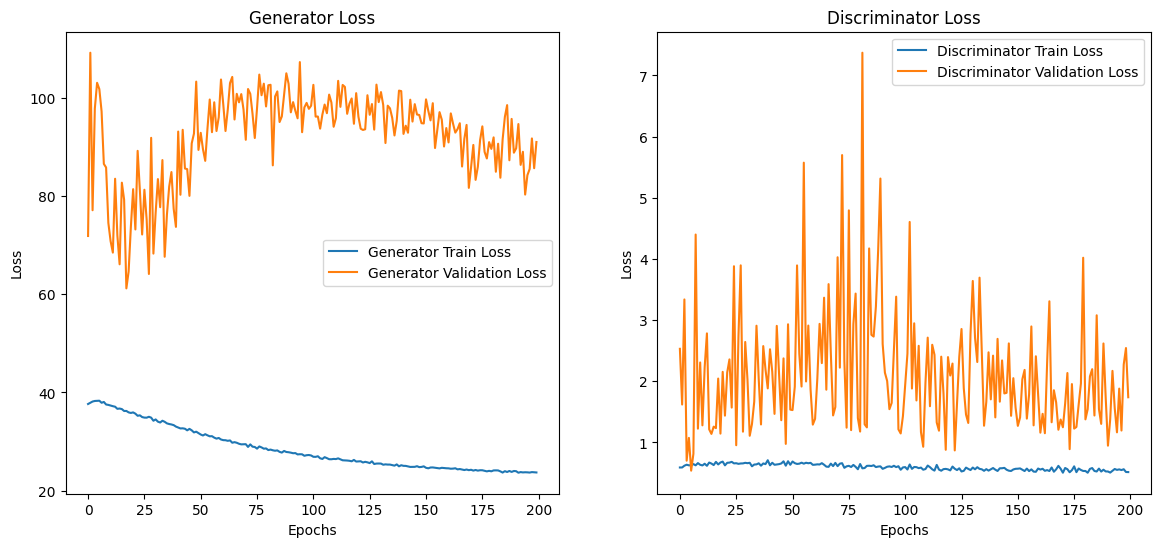

In [35]:
fit(train_dataset, test_dataset, epochs=200)

## Avaliação do modelo

In [36]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

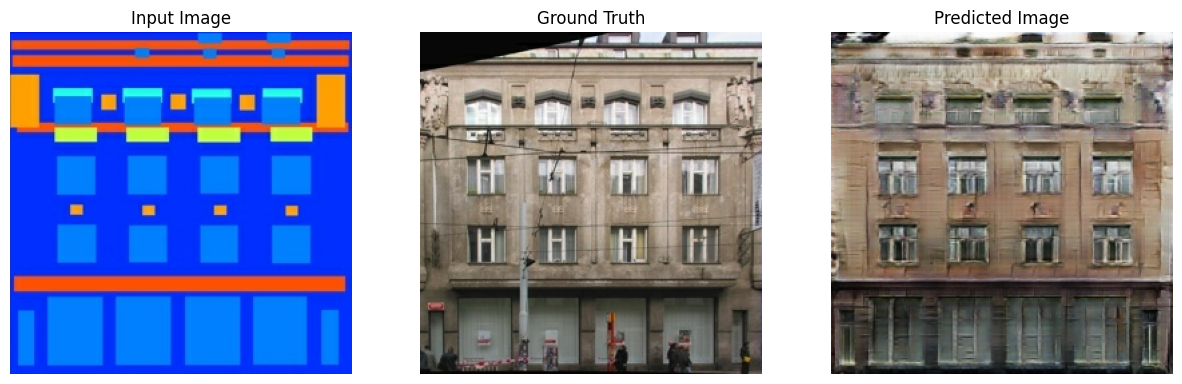

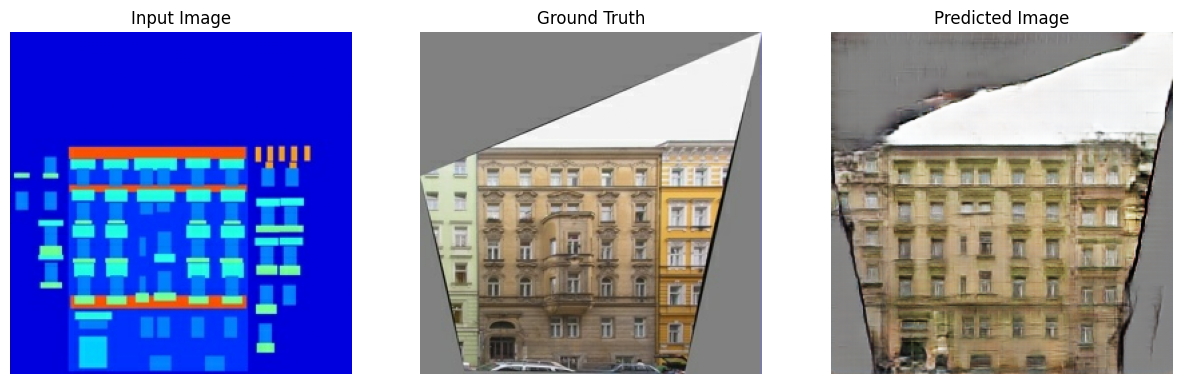

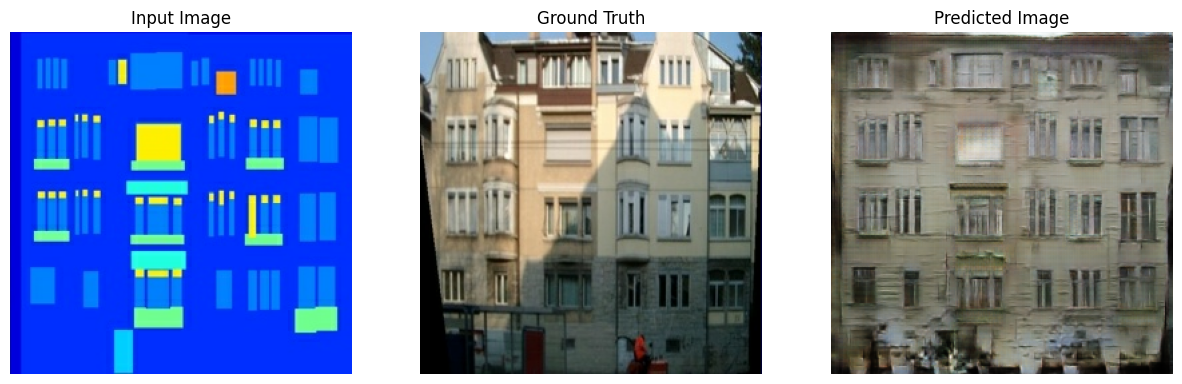

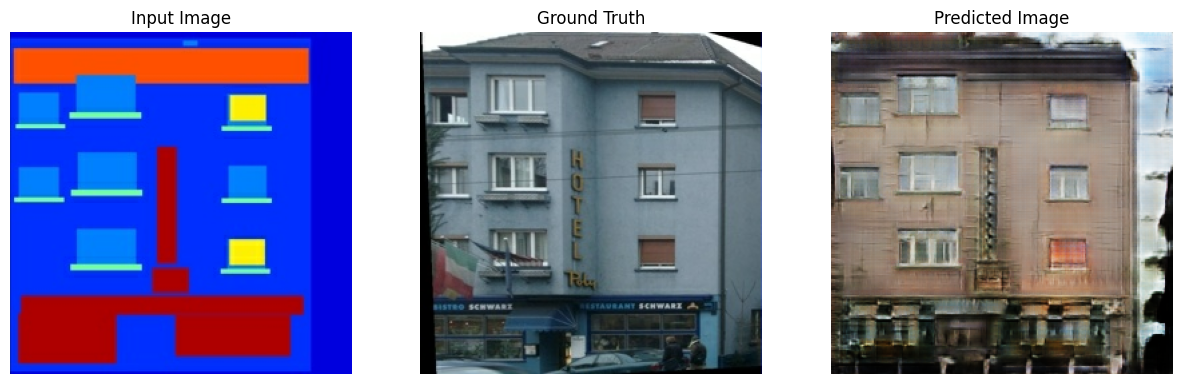

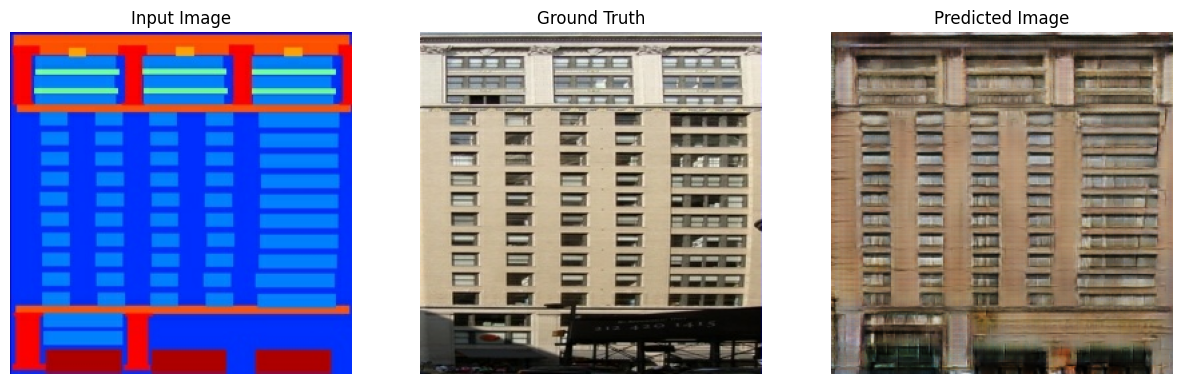

In [41]:
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

## Conclusão

Os resultados qualitativos obtidos com o modelo Pix2Pix foram notavelmente interessantes. O gerador demonstrou a capacidade de preservar os elementos principais das segmentações fornecidas como entrada, e, em muitos casos, conseguiu recuperar quase que perfeitamente a imagem real correspondente. Esses resultados indicam que o modelo conseguiu capturar a estrutura subjacente das imagens de maneira eficiente, o que é um excelente indicativo do sucesso da abordagem implementada.

Ao analisar o comportamento das perdas (loss) do gerador e do discriminador, observou-se o padrão esperado de oscilações, uma característica comum em redes adversariais generativas (GANs), devido à natureza competitiva entre as duas redes. No entanto, as perdas de treinamento apresentaram um comportamento mais estável e tendencialmente descendente, o que sugere que o modelo estava aprendendo de forma consistente ao longo das épocas.

Por outro lado, as perdas no conjunto de validação variaram mais significativamente. Essa variação pode indicar que o modelo estava enfrentando desafios em generalizar para exemplos fora do conjunto de treinamento. Contudo, é importante destacar que, mesmo com essa variabilidade nas perdas de validação, os resultados qualitativos permaneceram sólidos. Isso demonstra que o modelo, apesar das oscilações, conseguiu alcançar um equilíbrio onde era capaz de produzir saídas de alta qualidade.

Além disso, essa observação reforça a ideia de que, em modelos de GANs, as métricas de perda, embora importantes, não são os únicos indicadores de desempenho. O foco na avaliação visual e qualitativa dos resultados gerados é crucial, especialmente em tarefas de tradução de imagens, onde a percepção humana da qualidade é um fator determinante.

No contexto deste trabalho, o comportamento observado tanto nas perdas quanto nos resultados finais sugere que o modelo foi bem-sucedido em aprender as relações complexas necessárias para a tradução de imagens.